In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random


2024-12-18 14:04:38.736531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734510878.748773   69571 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734510878.752322   69571 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 14:04:38.765870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_dir = 'data/train'  # path to your training directory
test_dir = 'data/test'    # path to your test directory


In [4]:
# Check classes
classes = sorted(os.listdir(train_dir))
print("Classes:", classes)

Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [5]:
# Check data distribution in training set
class_counts = {}
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))
print("Class distribution in training data:", class_counts)


Class distribution in training data: {'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [6]:
#-------------------------------------------------------------------
# DATASET CREATION
# Create train & validation dataset with image size 180x180 and batch size 32
#-------------------------------------------------------------------
img_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


I0000 00:00:1734510880.343890   69571 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# Prefetch for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

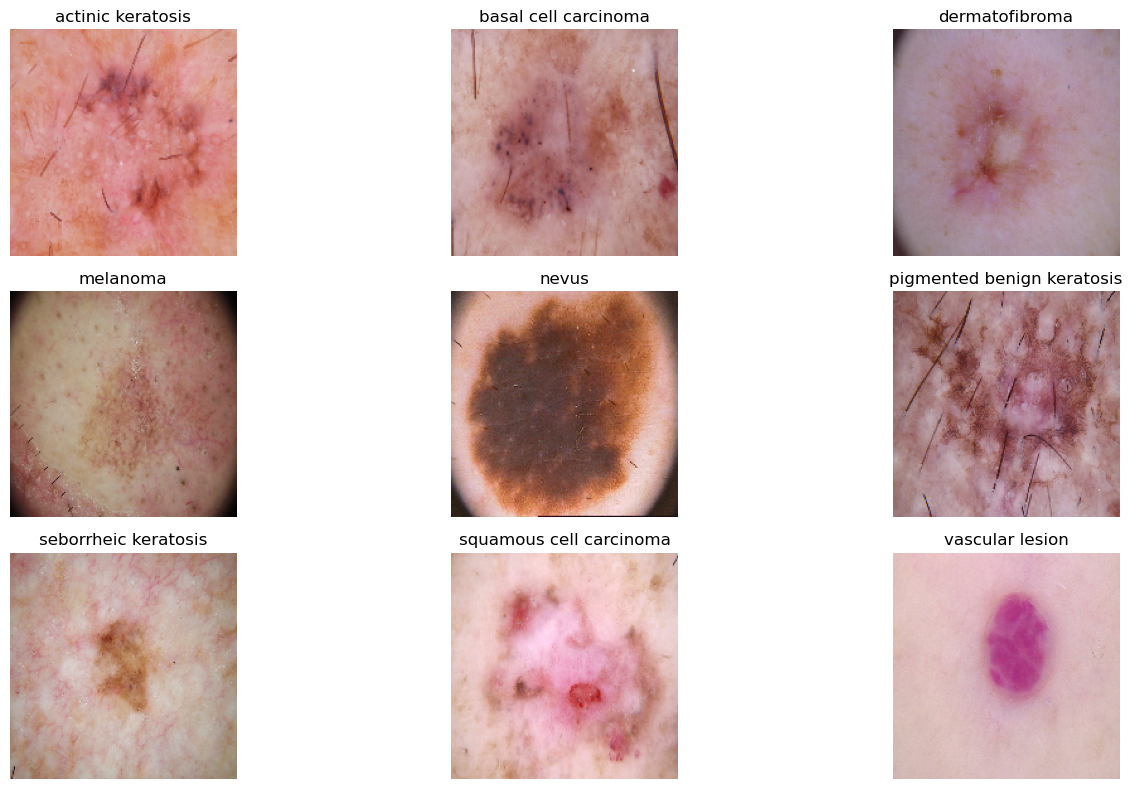

In [8]:
#-------------------------------------------------------------------
# DATASET VISUALIZATION
# Visualize one sample image from each class
#-------------------------------------------------------------------
plt.figure(figsize=(15, 8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_files = os.listdir(cls_path)
    # Filter to ensure we only pick image files
    img_files = [f for f in img_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(img_files) > 0:
        sample_img = random.choice(img_files)
        img_path = os.path.join(cls_path, sample_img)
        img = tf.keras.utils.load_img(img_path, target_size=img_size)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
#-------------------------------------------------------------------
# INITIAL MODEL BUILDING & TRAINING (NO AUGMENTATION)
#-------------------------------------------------------------------
num_classes = len(classes)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

/home/alpesh/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,043,913 (11.61 MB)

 Trainable params: 3,043,913 (11.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1734510884.621065   69688 service.cc:148] XLA service 0x7a9bac002210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734510884.621087   69688 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-12-18 14:04:44.645286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734510884.771742   69688 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/56 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1834 - loss: 2.1705

I0000 00:00:1734510889.253024   69688 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.1927 - loss: 2.0910 - val_accuracy: 0.2215 - val_loss: 1.9637
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2467 - loss: 1.9694 - val_accuracy: 0.2506 - val_loss: 1.8815
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2789 - loss: 1.8929 - val_accuracy: 0.2953 - val_loss: 1.8517
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3350 - loss: 1.8170 - val_accuracy: 0.3512 - val_loss: 1.8195
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3352 - loss: 1.7969 - val_accuracy: 0.3870 - val_loss: 1.6428
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4475 - loss: 1.6537 - val_accuracy: 0.4743 - val_loss: 1.5213
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4554 - loss: 1.5838 - val_accuracy: 0.5034 - val_loss: 1.4550
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4582 - loss: 1.5573 - val_accuracy: 0.5324 - val_loss: 1

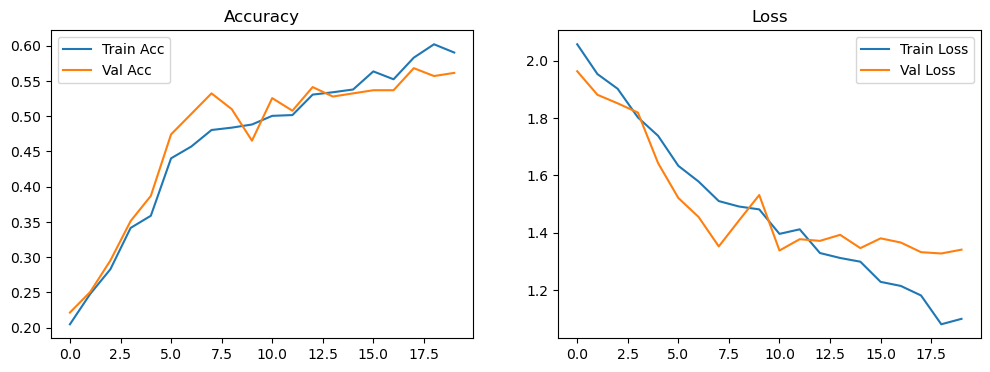

In [10]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# After analysis, we apply data augmentation.

#-------------------------------------------------------------------
# DATA AUGMENTATION
#-------------------------------------------------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

In [12]:
#-------------------------------------------------------------------
# MODEL RE-TRAINING WITH AUGMENTATION
#-------------------------------------------------------------------
model_aug = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_aug.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_aug = model_aug.fit(augmented_train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.2155 - loss: 2.0616 - val_accuracy: 0.3043 - val_loss: 1.8451
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3302 - loss: 1.8110 - val_accuracy: 0.4519 - val_loss: 1.5385
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3986 - loss: 1.6382 - val_accuracy: 0.4810 - val_loss: 1.4727
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4358 - loss: 1.5732 - val_accuracy: 0.4564 - val_loss: 1.4890
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4568 - loss: 1.4968 - val_accuracy: 0.5235 - val_loss: 1.4075
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4911 - loss: 1.4751 - val_accuracy: 0.4877 - val_loss: 1.5506
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4896 - loss: 1.4582 - val_accuracy: 0.5302 - val_loss: 1.4081
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4949 - loss: 1.4122 - val_accuracy: 0.5257 - v

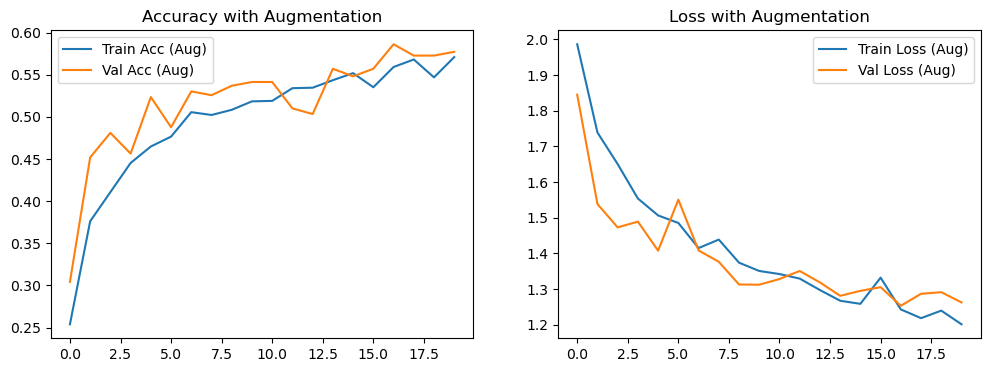

In [13]:
# Plot training results for augmented model
acc_aug = history_aug.history['accuracy']
val_acc_aug = history_aug.history['val_accuracy']
loss_aug = history_aug.history['loss']
val_loss_aug = history_aug.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc_aug, label='Train Acc (Aug)')
plt.plot(val_acc_aug, label='Val Acc (Aug)')
plt.legend()
plt.title('Accuracy with Augmentation')

plt.subplot(1,2,2)
plt.plot(loss_aug, label='Train Loss (Aug)')
plt.plot(val_loss_aug, label='Val Loss (Aug)')
plt.legend()
plt.title('Loss with Augmentation')
plt.show()

In [14]:
#-------------------------------------------------------------------
# CLASS DISTRIBUTION ANALYSIS
#-------------------------------------------------------------------
print("Class counts:", class_counts)
least_class = min(class_counts, key=class_counts.get)
most_class = max(class_counts, key=class_counts.get)
print("Least Class:", least_class, "Count:", class_counts[least_class])
print("Most Class:", most_class, "Count:", class_counts[most_class])

#-------------------------------------------------------------------
# HANDLING CLASS IMBALANCES WITH AUGMENTOR
# This step requires the Augmentor library and might need to be run outside
# the notebook environment. After augmentation, the dataset directory will
# contain more images for minority classes.

Class counts: {'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}
Least Class: seborrheic keratosis Count: 77
Most Class: pigmented benign keratosis Count: 462


In [15]:
import Augmentor


In [16]:
# Determine target count (max class count)
target_count = max(class_counts.values())
print("Target count for balancing:", target_count)

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    current_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    samples_to_generate = target_count - current_count
    if samples_to_generate > 0:
        p = Augmentor.Pipeline(source_directory=class_path, output_directory=class_path)
        p.flip_left_right(probability=0.5)
        p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
        p.zoom(probability=0.3, min_factor=1.1, max_factor=1.5)
        p.sample(samples_to_generate)

Target count for balancing: 462
Initialised with 114 image(s) found.
Output directory set to data/train/actinic keratosis/data/train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A9CD7EC8790>: 100%|██████████| 348/348 [00:01<00:00, 322.79 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to data/train/basal cell carcinoma/data/train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A9CE0DA16D0>: 100%|██████████| 86/86 [00:00<00:00, 316.65 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to data/train/dermatofibroma/data/train/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A9CD7E99650>: 100%|██████████| 367/367 [00:01<00:00, 317.56 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to data/train/melanoma/data/train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A9CD7ECA910>: 100%|██████████| 24/24 [00:00<00:00, 29.10 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to data/train/nevus/data/train/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A9CD7EA0510>: 100%|██████████| 105/105 [00:01<00:00, 64.27 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to data/train/seborrheic keratosis/data/train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A9CE0DA16D0>: 100%|██████████| 385/385 [00:02<00:00, 141.31 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to data/train/squamous cell carcinoma/data/train/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A9CD7F60850>: 100%|██████████| 281/281 [00:00<00:00, 320.00 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to data/train/vascular lesion/data/train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A9CD7E771D0>: 100%|██████████| 323/323 [00:01<00:00, 312.78 Samples/s]                  


In [17]:
# After running the Augmentor pipeline, reload the datasets with balanced data
train_ds_balanced = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds_balanced = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

train_ds_balanced = train_ds_balanced.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_balanced = val_ds_balanced.cache().prefetch(tf.data.experimental.AUTOTUNE)


Found 4158 files belonging to 9 classes.
Using 3327 files for training.
Found 4158 files belonging to 9 classes.
Using 831 files for validation.


In [18]:
#-------------------------------------------------------------------
# MODEL BUILDING & TRAINING AFTER HANDLING CLASS IMBALANCES
#-------------------------------------------------------------------
model_balanced = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_balanced.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_balanced = model_balanced.fit(train_ds_balanced, validation_data=val_ds_balanced, epochs=30)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.1405 - loss: 2.1561 - val_accuracy: 0.2647 - val_loss: 1.8752
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2981 - loss: 1.7405 - val_accuracy: 0.3285 - val_loss: 1.7141
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3761 - loss: 1.5868 - val_accuracy: 0.3538 - val_loss: 1.5880
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3792 - loss: 1.5447 - val_accuracy: 0.4079 - val_loss: 1.4746
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4313 - loss: 1.4596 - val_accuracy: 0.4296 - val_loss: 1.4835
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4041 - loss: 1.4944 - val_accuracy: 0.4272 - val_loss: 1.4571
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4631 - loss: 1.4031 - val_accuracy: 0.4633 - val_loss: 1.4056
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4574 - loss: 1.3897 - val_acc

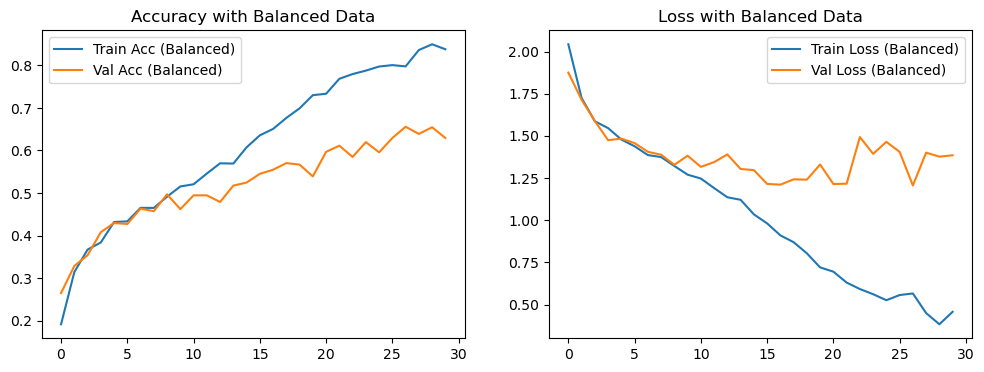

In [19]:
# Plot training results for balanced dataset model
acc_bal = history_balanced.history['accuracy']
val_acc_bal = history_balanced.history['val_accuracy']
loss_bal = history_balanced.history['loss']
val_loss_bal = history_balanced.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc_bal, label='Train Acc (Balanced)')
plt.plot(val_acc_bal, label='Val Acc (Balanced)')
plt.legend()
plt.title('Accuracy with Balanced Data')

plt.subplot(1,2,2)
plt.plot(loss_bal, label='Train Loss (Balanced)')
plt.plot(val_loss_bal, label='Val Loss (Balanced)')
plt.legend()
plt.title('Loss with Balanced Data')
plt.show()
